# Prediction of the NRDD with Dense Neural Networks

The uniformity criterion was predicted before with a tuned LightGBM model and the goal of this chapter is to compare the performance with a dense neural network model

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Normalization
import tensorflow.keras.backend as K
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle

In [4]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [5]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [6]:
# List of the explanatory variables
lst_param = df_params.columns.to_list()

# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

In [7]:
# Scale all explanatory variables, except the slot class encoded columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[lst_expl])
X_scaled = pd.concat([pd.DataFrame(X_scaled, columns=lst_expl, index=X.index), X[lst_slot_class]], axis=1)
X_scaled

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,0.052038,0.675477,0.268415,-0.964606,-1.216650,-0.108340,-0.428067,0.972486,0.351407,-1.234165,...,-1.180056,-0.998197,1.186053,-0.393300,-0.288377,-0.617930,0,0,0,1
1,-1.341835,0.959596,-1.619352,1.026687,-0.996598,0.162988,-0.592297,0.290194,-0.021012,1.042796,...,1.632010,-0.762137,-0.141535,1.592878,-0.623407,-0.590973,0,0,0,1
2,0.735987,-1.140108,-1.645330,-0.372413,-1.046831,0.615201,-1.163032,-1.319075,-0.011177,-0.651763,...,-0.942469,-1.417812,-0.872893,-1.224991,-0.564514,-0.184940,0,0,0,1
3,-1.289889,-1.257914,-1.472140,1.511524,-0.564882,-1.440733,-1.047000,0.358075,0.484408,-1.216083,...,1.141323,0.676109,0.111121,-1.076670,-1.132485,-0.339844,0,0,0,1
4,0.519548,-0.443672,0.900556,-0.740273,-0.986367,0.104873,-0.057193,1.012866,0.168618,1.111047,...,-1.348848,-0.708940,-0.831592,-1.280280,-0.538616,-0.799752,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,0.155929,-0.173413,-0.407025,-0.071506,1.944072,-0.562863,-0.783161,0.487223,-1.644638,0.338918,...,-1.162380,-0.310659,1.307600,1.497900,1.311448,-0.418957,1,0,0,0
7986,1.099606,-0.939147,0.510880,-0.218112,1.176576,0.495893,-0.158801,-0.123411,-0.523212,-1.668875,...,-0.729932,0.206345,0.998675,1.617276,1.651811,-0.717983,1,0,0,0
7987,-0.857009,-0.758974,-0.640831,0.731937,2.026256,0.345412,-0.382511,-0.528452,-1.660220,0.379828,...,1.271914,0.909537,0.438064,-1.066910,1.269786,-0.683877,1,0,0,0
7988,-0.337554,-0.173413,-0.510938,-1.405192,1.372308,-1.397244,-0.578444,-0.788036,0.288562,-1.670127,...,0.500178,0.463600,-0.127121,1.730853,1.534690,-0.553233,1,0,0,0


In [8]:
# Target variable: NRDD
target = 'long_disp_nrdd'
y = df_params[[target]]

In [9]:
# We store the number of explanatory variables for later
num_expl = X.shape[1]
print ('Number of explanatory variables:', num_expl)

Number of explanatory variables: 27


# Prediction of the Normalized Relative Displacement Deviation of the output displacement

We will use a 5-fold cross validation all along the notebook to evaluate the models

In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=55)

### Baseline model

We start with the baseline model: the model has 2 layers (first layer with the same numbers of neurons as the Input layer and second layer with one neuron). The structure of the model will be optimized in the next steps. The following function creates and returns the Keras sequential model:

In [18]:
def baseline_model():

    model = Sequential(name='baseline_model')    # Instantiate a sequential model
    model.add(Dense(num_expl, input_shape=(num_expl,), kernel_initializer='normal', activation='relu', name='Dense_Layer_1'))
    model.add(Dense(1, kernel_initializer='normal', name='Dense_Layer_2'))

    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))

    return model

### Modeling the standardized dataset with a pipeline and perform some transformations to the target variable

The pipeline framework performs the standardization during the model evaluation process and prevents data leakage from each test set cross validation fold into the training data. We will try to predict a transformation of the NRDD instead of the target variable itself. The cross-validation scoring will highlight the best transformation.

In [13]:
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=baseline_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0))
                    ])
                    

In [44]:
dict_transfs = {'NoTransformation': FunctionTransformer(lambda y: y),
                'Inverse': FunctionTransformer(lambda y: 1/y),
                'InverseSquare': FunctionTransformer(lambda y: 1/y**2),
                'Logarithm': FunctionTransformer(np.log10),
                'InverseLogarithm': FunctionTransformer(lambda y: 1/np.log10(y)),
                'LogarithmInverse': FunctionTransformer(lambda y: np.log10(1/y)),
                'StandardScaler': StandardScaler(),
                'PowerTransformer': PowerTransformer(),
                'QuantileTransformer': QuantileTransformer(),
                'RobustScaler': RobustScaler(),
                'RootSquare': FunctionTransformer(lambda y: np.sqrt(y)),
                'InverseRootSquare': FunctionTransformer(lambda y: 1/np.sqrt(y))
            }

results = pd.DataFrame()

for name, transf in dict_transfs.items():

    print ('---------------')
    print ('** Transformation:', name)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

    # Apply the transformation
    y_transf = transf.fit_transform(y_train)  

    # Apply the StandardScaler
    X_train_scaled = scaler.fit_transform(X_train[lst_expl])
    X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=lst_expl, index=X_train.index), X_train[lst_slot_class]], axis=1)

    scores = cross_val_score(pipe, X_train_scaled, y_transf, cv=kfold)
    results[name] = pd.DataFrame([scores.mean(), scores.std()], index=['Score Mean', 'Standard Deviation'])

results

---------------
** Transformation: NoTransformation
---------------
** Transformation: Inverse
---------------
** Transformation: InverseSquare
---------------
** Transformation: Logarithm
---------------
** Transformation: InverseLogarithm
---------------
** Transformation: LogarithmInverse
---------------
** Transformation: StandardScaler
---------------
** Transformation: PowerTransformer
---------------
** Transformation: QuantileTransformer
---------------
** Transformation: RobustScaler
---------------
** Transformation: RootSquare
---------------
** Transformation: InverseRootSquare


,NoTransformation,Inverse,InverseSquare,Logarithm,InverseLogarithm,LogarithmInverse,StandardScaler,PowerTransformer,QuantileTransformer,RobustScaler,RootSquare,InverseRootSquare
Score Mean,0.568569,0.035919,-0.077447,0.449575,0.436263,0.330514,0.423012,0.592207,0.501210,0.428361,0.508949,0.015579
Standard Deviation,0.059864,0.193893,0.090887,0.028970,0.014163,0.136263,0.062815,0.035692,0.028844,0.045653,0.025456,0.260553


The PowerTransformer provides the best score of cross-validation and will be chosen in the next optimization steps. This transformation is used to make numerical data more Gaussian-like by stabilizing variance and reducing skewness.

### First tuning of the Neural Network topology

The following models will work with the transformed target variable. The structure of a neural network is the biggest leverage to improve the performance of the model (number of layers and neurons, activation functions, ...). Then we use the GridSearch technique to optimize the model structure.

In [13]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)
idx_train = X_train.index
idx_test = X_test.index

transf = PowerTransformer()
w_train = transf.fit_transform(y_train.values.reshape(-1, 1)) 
w_test = transf.transform(y_test.values.reshape(-1, 1))

A new function is defined taking the tuning parameters as arguments:
* Number of epochs and batch size
* Number of neurons of the hidden layer (default: number of input variables)
* Learning rate of the optimizer
* Initialization of the network weights
* Neuron activation function

In [16]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
    model.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

* The weight initialization is identical for each layer and picked by default according a normal distribution
* The default activation function of the first layer is reLU

#### Tune the batch size and number of epochs

In [17]:
lst_batch_size = [500, 750, 1000, 1250, 1500]
lst_epochs = [75, 100, 125, 140, 150, 160]
params = {'mlp__batch_size': lst_batch_size, 'mlp__epochs': lst_epochs}

In [18]:
grid = GridSearchCV(estimator=pipe_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, w_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.796704 (0.019332) with: {'mlp__batch_size': 500, 'mlp__epochs': 75}
0.796371 (0.025554) with: {'mlp__batch_size': 500, 'mlp__epochs': 100}
0.776196 (0.047358) with: {'mlp__batch_size': 500, 'mlp__epochs': 125}
0.793305 (0.018283) with: {'mlp__batch_size': 500, 'mlp__epochs': 140}
0.787842 (0.015228) with: {'mlp__batch_size': 500, 'mlp__epochs': 150}
0.786982 (0.010130) with: {'mlp__batch_size': 500, 'mlp__epochs': 160}
0.796440 (0.008003) with: {'mlp__batch_size': 750, 'mlp__epochs': 75}
0.799710 (0.011067) with: {'mlp__batch_size': 750, 'mlp__epochs': 100}
0.789853 (0.010678) with: {'mlp__batch_size': 750, 'mlp__epochs': 125}
0.805460 (0.012420) with: {'mlp__batch_size': 750, 'mlp__epochs': 140}
0.803724 (0.008548) with: {'mlp__batch_size': 750, 'mlp__epochs': 150}
0.793849 (0.016888) with: {'mlp__batch_size': 750, 'mlp__epochs': 160}
0.763009 (0.038362) with: {'mlp__batch_size': 1000, 'mlp__epochs': 75}
0.805919 (0.013813) with: {'mlp__batch_size': 1000, 'mlp__epochs': 100}
0.80178

* Best batch size: 1000
* Best number of epochs: 100

#### Tune the learning rate of the Adam optimizer

In [19]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
    model.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, loss='mse', optimizer='Adam', epochs=100, batch_size=1000, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [20]:
lst_learning_rate = np.linspace(-2, 1, 20)
params = {'mlp__optimizer__learning_rate': 10**lst_learning_rate} 

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, w_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.778468 (0.015848) with: {'mlp__optimizer__learning_rate': 0.01}
0.783100 (0.019768) with: {'mlp__optimizer__learning_rate': 0.01438449888287663}
0.805863 (0.023105) with: {'mlp__optimizer__learning_rate': 0.0206913808111479}
0.810801 (0.019421) with: {'mlp__optimizer__learning_rate': 0.029763514416313176}
0.810919 (0.021946) with: {'mlp__optimizer__learning_rate': 0.04281332398719394}
0.807291 (0.014542) with: {'mlp__optimizer__learning_rate': 0.06158482110660264}
0.809587 (0.012639) with: {'mlp__optimizer__learning_rate': 0.08858667904100823}
0.778392 (0.021109) with: {'mlp__optimizer__learning_rate': 0.12742749857031335}
0.778910 (0.024660) with: {'mlp__optimizer__learning_rate': 0.18329807108324356}
0.760065 (0.025382) with: {'mlp__optimizer__learning_rate': 0.26366508987303583}
0.709098 (0.052412) with: {'mlp__optimizer__learning_rate': 0.37926901907322497}
0.679842 (0.049147) with: {'mlp__optimizer__learning_rate': 0.5455594781168517}
0.541587 (0.140272) with: {'mlp__optimizer__

The learning rate shows an optimum between 0.03 and 0.06. The value 0.043 is kept for the further optimizations.

#### Tune the number of neurons of the hidden layer

In the baseline model, the hidden layer has the same size as the input layer. We tune it between 15 and 34 neurons.

In [21]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
    model.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.043))

    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=1000, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [22]:
lst_nb_neurons = np.arange(15, 35, 1)
params = {'mlp__model__nb_neurons': lst_nb_neurons}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, w_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.787134 (0.017675) with: {'mlp__model__nb_neurons': 15}
0.798675 (0.026476) with: {'mlp__model__nb_neurons': 16}
0.808846 (0.005051) with: {'mlp__model__nb_neurons': 17}
0.802826 (0.018651) with: {'mlp__model__nb_neurons': 18}
0.812111 (0.014145) with: {'mlp__model__nb_neurons': 19}
0.806694 (0.006547) with: {'mlp__model__nb_neurons': 20}
0.798858 (0.027366) with: {'mlp__model__nb_neurons': 21}
0.807620 (0.016525) with: {'mlp__model__nb_neurons': 22}
0.810683 (0.014030) with: {'mlp__model__nb_neurons': 23}
0.806801 (0.018382) with: {'mlp__model__nb_neurons': 24}
0.816532 (0.016012) with: {'mlp__model__nb_neurons': 25}
0.811997 (0.015811) with: {'mlp__model__nb_neurons': 26}
0.813137 (0.020551) with: {'mlp__model__nb_neurons': 27}
0.810125 (0.011737) with: {'mlp__model__nb_neurons': 28}
0.815933 (0.013466) with: {'mlp__model__nb_neurons': 29}
0.813096 (0.017546) with: {'mlp__model__nb_neurons': 30}
0.816480 (0.013294) with: {'mlp__model__nb_neurons': 31}
0.804342 (0.013855) with: {'mlp

* Best number of neurons for the hidden layer: 25

#### Tune the weight initialization and the activation function

In [23]:
def start_tuning_model(init_mode='normal', activation='relu'):
    model = Sequential()
    model.add(Dense(25, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
    model.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.043))
    
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=1000, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [24]:
lst_init_mode = ['normal', 'uniform', 'lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
lst_activation = ['relu', 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
params = {'mlp__model__init_mode': lst_init_mode, 'mlp__model__activation': lst_activation}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, w_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.816532 (0.016012) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'normal'}
0.819470 (0.013786) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'uniform'}
0.804869 (0.010210) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'lecun_uniform'}
-0.000563 (0.000505) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'zero'}
0.814206 (0.015752) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_normal'}
0.808614 (0.004932) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_uniform'}
0.802726 (0.018637) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_normal'}
0.815460 (0.014187) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_uniform'}
0.822342 (0.017127) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'normal'}
0.815521 (0.007884) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'uniform'}
0.81

The best results are obtained for:
* the Softmax activation functions
* the normal weight initializer.


In [25]:
# Check the score again
print ('Score of the test set:', grid_result.score(X_test, w_test))

Score of the test set: 0.8541859658399016


Redefine and dump the best model

In [14]:
nb_neurons = 25
init_mode = 'normal'
activation = 'softmax'
learning_rate = 0.043

In [15]:
# Preprocessing
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

# Define the Keras regressor
regressor = Sequential()
regressor.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
regressor.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
regressor.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

# Create the main pipeline
pipe_tuned_regr = Pipeline(steps=[                        
                        ('preprocessor', preprocessor),
                        ('regressor', KerasRegressor(model=regressor, epochs=100, batch_size=1000, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                        ])

In [16]:
# Check the score again
pipe_tuned_regr.fit(X_train, w_train)
print ('Score of the test set:', pipe_tuned_regr.score(X_test, w_test))

Score of the test set: 0.8550440040374117


In [17]:
# Dump the best model: 
dump_dir = os.path.join(base_dir, 'Scripts', 'model_dumps')
pickle.dump(pipe_tuned_regr, open(os.path.join(dump_dir, '5_model_neuralnetw_tuned_long_displacements.pkl'), 'wb'))
pickle.dump(transf, open(os.path.join(dump_dir, '5_model_neuralnetw_tuned_transformer.pkl'), 'wb'))

INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmp6b5lwota\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmp6b5lwota\assets


### History of the fitted model

In [8]:
# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

y = df_params[['long_disp_nrdd']]

num_expl = X.shape[1]

In [9]:
# New train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)
idx_train = X_train.index
idx_test = X_test.index

In [10]:
# Apply the StandardScaler to the explanatory variables of the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[lst_expl])
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=lst_expl, index=idx_train), X_train[lst_slot_class]], axis=1)

In [11]:
# Apply the PowerTransformer to the target variable
transf = PowerTransformer()
w_train = pd.DataFrame(transf.fit_transform(y_train), index=idx_train)

In [12]:
# The coefficient of determination R² is not included in the Keras metrics by default but it would be useful to compare the performance with the other estimators previouly investigated. 
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true-y_pred))
    ss_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return 1 - ss_res/ss_tot

The model is compiled with the Adam optimization algorithm and the mean squared error as the loss function is used. The metric R² will be used again to evaluate its performance: 

In [16]:
model_1 = Sequential(name='tuned_model')
model_1.add(Dense(25, input_shape=(num_expl,), kernel_initializer='normal', activation='softmax', name='Dense_Layer_1'))
model_1.add(Dense(1, kernel_initializer='normal', name='Dense_Layer_2'))
model_1.compile(loss='mse', optimizer=Adam(learning_rate=0.043), metrics=[r2_score])

In [17]:
model_1.summary()

Model: "tuned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_Layer_1 (Dense)       (None, 25)                700       
                                                                 
 Dense_Layer_2 (Dense)       (None, 1)                 26        
                                                                 
Total params: 726 (2.84 KB)
Trainable params: 726 (2.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The training information is stored in the history object:

In [37]:
history = model_1.fit(X_train_scaled, w_train, epochs=100, batch_size=1000, verbose=0, validation_split=0.2)

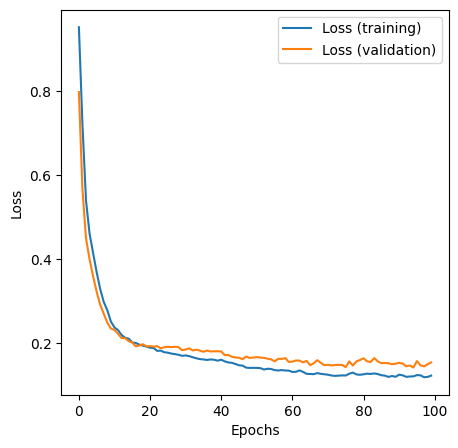

In [38]:
# Plot of the evoluation of the loss during the training
fig = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

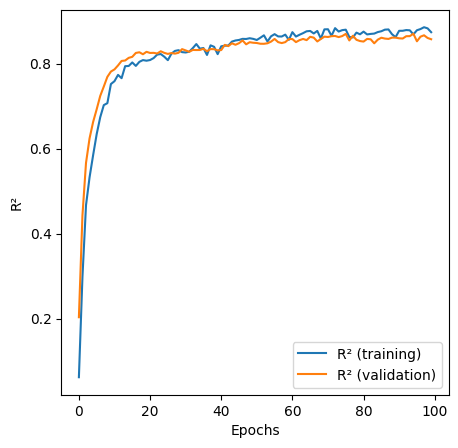

In [39]:
# Plot of the evoluation of the metric during the training
fig = plt.figure(figsize=(5, 5))
plt.plot(history.history['r2_score'], label='R² (training)')
plt.plot(history.history['val_r2_score'], label='R² (validation)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.show()

The value of the loss function and of the evaluation metric remain stable during the training. The R² value is not dramatically lower in the validation set than in the training set, which means that a slight overfitting is present. Anyway the training process can be considered as successful.

 The predictions are calculated with the test set of the data and transformed back:

In [40]:
X_test_scaled = scaler.transform(X_test[lst_expl])
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns=lst_expl, index=idx_test), X_test[lst_slot_class]], axis=1)

w_test = pd.DataFrame(transf.transform(y_test), index=idx_test)
w_pred = pd.DataFrame(model_1.predict(X_test_scaled), index=idx_test)
y_pred = pd.DataFrame(transf.inverse_transform(w_pred), index=idx_test)

50/50 [==============================] - 0s 1ms/step


c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


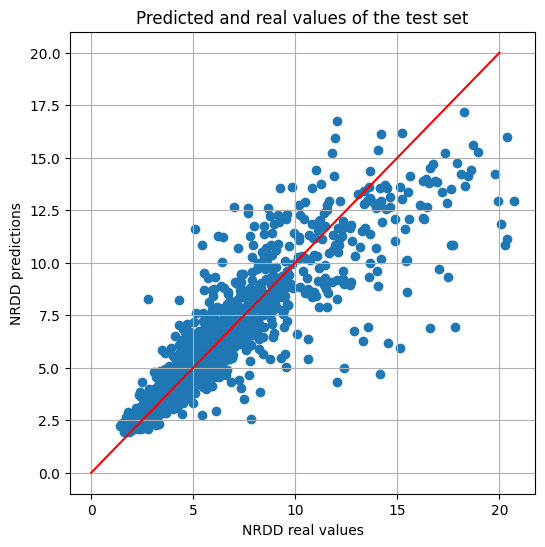

In [47]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 20], [0, 20], color='r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predictions')
plt.title('Predicted and real values of the test set')
plt.grid(True)
plt.show()

The spreading of the predictions for great values of the NRDD will be discussed in the next notebook devoted to the interpretation